# Logistic Regression Models for Pitcher Injury Prediction (2018-2025 → 2026 Forecast)

This notebook implements three variants of Logistic Regression to forecast pitcher injury probability for the 2026 season using data from 2018-2025.

## Model Variants:

**Model 1: Baseline (Unmodifiable Attributes Only)**
- Philosophy: "Can we predict injury from things the pitcher/org can't change?"
- Features: Age (+ age²), Height, Weight, BMI, Birth country, Previous injury history

**Model 2: Modifiable Attributes Only (Workload + Biomechanics)**
- Philosophy: "Can we predict injury from things the org can control?"
- Features: Workload metrics, Pitch mix, Velocity, Mechanics (release point consistency), Biomechanics

**Model 3: Full Model (Unmodifiable + Modifiable)**
- Philosophy: "Use everything we know"
- Features: All features from Model 1 + Model 2


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, accuracy_score, precision_score, 
                            recall_score, f1_score, log_loss)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Data Loading and Exploration


In [3]:
# Load the data
df = pd.read_csv('mlb_injuries.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['had_arm_injury_this_year'].value_counts())
print(f"\nInjury rate: {df['had_arm_injury_this_year'].mean():.3f}")
print(f"\nYears available: {sorted(df['game_year'].unique())}")
print(f"\nMissing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0])


Dataset shape: (6300, 60)

Target variable distribution:
had_arm_injury_this_year
0.0    4994
1.0    1306
Name: count, dtype: int64

Injury rate: 0.207

Years available: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Missing values per column:
Series([], dtype: int64)


In [4]:
# Prepare data for modeling
# Filter data from 2018-2025 (for forecasting 2026)
df_model = df[df['game_year'] <= 2025].copy()

# Create age squared feature
df_model['age_squared'] = df_model['age'] ** 2

# Target variable
target = 'had_arm_injury_this_year'
y = df_model[target].copy()

print(f"Modeling dataset shape: {df_model.shape}")
print(f"Injury rate: {df_model[target].mean():.3f}")

# Create a single train/test split for fair comparison across all models
# Use a simple feature column for splitting, then extract indices
X_dummy = df_model[['age']].copy()
X_dummy_train, X_dummy_test, y_train_temp, y_test_temp = train_test_split(
    X_dummy, y, test_size=0.2, random_state=42, stratify=y
)

# Extract indices from the split
train_idx = X_dummy_train.index
test_idx = X_dummy_test.index

# Define y_train and y_test for use across all models
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print(f"\nTrain set size: {len(train_idx)}")
print(f"Test set size: {len(test_idx)}")
print(f"Train injury rate: {y_train.mean():.3f}")
print(f"Test injury rate: {y_test.mean():.3f}")


Modeling dataset shape: (6300, 61)
Injury rate: 0.207

Train set size: 5040
Test set size: 1260
Train injury rate: 0.207
Test injury rate: 0.207


---

## Model 1: Baseline (Unmodifiable Attributes Only)

**Features:**
- Age + Age²
- Height
- Weight  
- BMI
- Birth country (categorical)
- Previous arm injury history


In [5]:
# Model 1: Unmodifiable attributes only
model1_features = ['age', 'age_squared', 'height', 'weight', 'bmi', 
                   'birth_country', 'prev_arm_inj_history']

# Prepare features
X1 = df_model[model1_features].copy()

# Handle categorical variables (birth_country)
X1 = pd.get_dummies(X1, columns=['birth_country'], prefix='country', drop_first=True)

# Use the same train/test split for all models
X1_train = X1.loc[train_idx]
X1_test = X1.loc[test_idx]
# y_train and y_test already defined from Cell 4

# Standardize features
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

# Fit logistic regression
model1 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model1.fit(X1_train_scaled, y_train)

# Predictions
y1_pred = model1.predict(X1_test_scaled)
y1_pred_proba = model1.predict_proba(X1_test_scaled)[:, 1]

# Metrics
print("=" * 60)
print("MODEL 1: Baseline (Unmodifiable Attributes Only)")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test, y1_pred):.4f}")
print(f"Precision: {precision_score(y_test, y1_pred):.4f}")
print(f"Recall: {recall_score(y_test, y1_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y1_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y1_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y1_pred_proba):.4f}")

# Cross-validation
cv_scores = cross_val_score(model1, X1_train_scaled, y_train, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='roc_auc')
print(f"\n5-Fold CV AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


MODEL 1: Baseline (Unmodifiable Attributes Only)

Accuracy: 0.8151
Precision: 0.5729
Recall: 0.4215
F1-Score: 0.4857
AUC-ROC: 0.6799
Log Loss: 0.6334

5-Fold CV AUC-ROC: 0.6910 (+/- 0.0381)


In [6]:
# Store Model 1 results
model1_results = {
    'model': model1,
    'scaler': scaler1,
    'feature_names': X1.columns.tolist(),
    'y_test': y_test,
    'y_pred': y1_pred,
    'y_pred_proba': y1_pred_proba,
    'accuracy': accuracy_score(y_test, y1_pred),
    'precision': precision_score(y_test, y1_pred),
    'recall': recall_score(y_test, y1_pred),
    'f1': f1_score(y_test, y1_pred),
    'auc_roc': roc_auc_score(y_test, y1_pred_proba),
    'log_loss': log_loss(y_test, y1_pred_proba)
}

# Display all coefficients sorted by absolute value
coef_df1 = pd.DataFrame({
    'Feature': X1.columns,
    'Coefficient': model1.coef_[0],
    'Abs_Coefficient': np.abs(model1.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "=" * 80)
print("MODEL 1: All Features with Absolute Coefficients")
print("=" * 80)
print(coef_df1.to_string(index=False))
print("=" * 80)



MODEL 1: All Features with Absolute Coefficients
                    Feature  Coefficient  Abs_Coefficient
       prev_arm_inj_history     0.779927         0.779927
                age_squared    -0.611020         0.611020
 country_Dominican Republic    -0.518995         0.518995
                        age     0.496650         0.496650
                country_USA    -0.488090         0.488090
          country_Nicaragua    -0.390738         0.390738
                     weight    -0.349008         0.349008
          country_Venezuela    -0.297352         0.297352
                        bmi     0.282575         0.282575
  country_Republic of Korea    -0.278888         0.278888
             country_Taiwan    -0.258231         0.258231
        country_Puerto Rico    -0.211560         0.211560
                     height     0.199986         0.199986
             country_Mexico    -0.179521         0.179521
       country_South Africa    -0.171651         0.171651
            country_Ge

---

## Model 2: Modifiable Attributes Only (Workload + Biomechanics) with Elastic Net Feature Selection

**Philosophy:** Use Elastic Net regularization to automatically select the best combination of modifiable features from ALL available workload, biomechanical, and mechanical metrics, then build a final Logistic Regression model with only the selected features.

**Features (All modifiable attributes):**
- **Workload**: num_pitches_thrown, pitches_per_game, bf_per_game, num_games, num_bf
- **Pitch Mix**: BB%, FB%, OS%
- **Velocity**: All avg and max velocities for BB, FB, OS
- **Mechanics**: hrel_sd, vrel_sd (release point consistency)
- **Biomechanics**: All avg and max spin rates, extension, horizontal break, induced vertical break, spin axis for all pitch types
- **Pitcher Role**: SP vs RP (categorical)

**Method:** 
1. **Step 1:** Elastic Net regularization (with grid search) selects optimal features through L1 (feature selection) and L2 (regularization) penalties
2. **Step 2:** Regular Logistic Regression model trained on only the selected features from Step 1


In [7]:
# Model 2: Modifiable attributes only - ALL features with Elastic Net
# Workload features
workload_features = ['num_pitches_thrown', 'pitches_per_game', 'bf_per_game', 'num_games', 'num_bf']

# Pitch mix features
pitch_mix_features = ['BB%', 'FB%', 'OS%']

# Velocity features - ALL avg and max velocities
velocity_features = [
    'BB_avg_velo', 'BB_max_velo',
    'FB_avg_velo', 'FB_max_velo',
    'OS_avg_velo', 'OS_max_velo'
]

# Mechanics features
mechanics_features = ['hrel_sd', 'vrel_sd']

# Biomechanics features - ALL avg and max for all pitch types
biomechanics_features = [
    # Breaking Ball (BB)
    'BB_avg_spin', 'BB_avg_ext', 'BB_avg_ivb', 'BB_avg_hb', 'BB_avg_spin_axis',
    'BB_max_spin', 'BB_max_ext', 'BB_max_ivb', 'BB_max_hb', 'BB_max_spin_axis',
    # Fastball (FB)
    'FB_avg_spin', 'FB_avg_ext', 'FB_avg_ivb', 'FB_avg_hb', 'FB_avg_spin_axis',
    'FB_max_spin', 'FB_max_ext', 'FB_max_ivb', 'FB_max_hb', 'FB_max_spin_axis',
    # Offspeed (OS)
    'OS_avg_spin', 'OS_avg_ext', 'OS_avg_ivb', 'OS_avg_hb', 'OS_avg_spin_axis',
    'OS_max_spin', 'OS_max_ext', 'OS_max_ivb', 'OS_max_hb', 'OS_max_spin_axis'
]

# Pitcher role
role_features = ['pitcher_role']

# Combine all modifiable features
model2_features = (workload_features + pitch_mix_features + velocity_features + 
                   mechanics_features + biomechanics_features + role_features)

print(f"Total modifiable features available: {len(model2_features)}")

# Prepare features
X2 = df_model[model2_features].copy()

# Handle categorical variable (pitcher_role)
X2 = pd.get_dummies(X2, columns=['pitcher_role'], prefix='role', drop_first=True)

print(f"Total features after encoding: {X2.shape[1]}")

# Use the same train/test split for all models
X2_train = X2.loc[train_idx]
X2_test = X2.loc[test_idx]
# y_train and y_test already defined

# Standardize features
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)


print("\nPerforming Grid Search for optimal Elastic Net parameters...")

# Elastic Net parameter grid
param_grid = {
    'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Base Elastic Net model
elastic_net_base = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    elastic_net_base,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X2_train_scaled, y_train)

# Get best Elastic Net model for feature selection
elastic_net_best = grid_search.best_estimator_

print(f"\nBest Elastic Net parameters:")
print(f"  C: {grid_search.best_params_['C']}")
print(f"  l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"  Best CV score: {grid_search.best_score_:.4f}")

# Extract selected features (non-zero coefficients)
selected_features_mask = np.abs(elastic_net_best.coef_[0]) > 1e-6
selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = X2.columns[selected_feature_indices].tolist()
n_selected = len(selected_feature_indices)

print(f"\nFeatures selected by Elastic Net: {n_selected} / {X2.shape[1]} ({100*n_selected/X2.shape[1]:.1f}%)")


# Prepare data with only selected features
X2_selected_train = X2_train.iloc[:, selected_feature_indices]
X2_selected_test = X2_test.iloc[:, selected_feature_indices]

# Standardize selected features
scaler2_selected = StandardScaler()
X2_selected_train_scaled = scaler2_selected.fit_transform(X2_selected_train)
X2_selected_test_scaled = scaler2_selected.transform(X2_selected_test)

# Fit regular Logistic Regression on selected features
model2 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model2.fit(X2_selected_train_scaled, y_train)

# Predictions
y2_pred = model2.predict(X2_selected_test_scaled)
y2_pred_proba = model2.predict_proba(X2_selected_test_scaled)[:, 1]

# Metrics
print(f"\nAccuracy: {accuracy_score(y_test, y2_pred):.4f}")
print(f"Precision: {precision_score(y_test, y2_pred):.4f}")
print(f"Recall: {recall_score(y_test, y2_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y2_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y2_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y2_pred_proba):.4f}")

# Cross-validation on final model
cv_scores = cross_val_score(model2, X2_selected_train_scaled, y_train, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='roc_auc')
print(f"\n5-Fold CV AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Total modifiable features available: 47
Total features after encoding: 47

Performing Grid Search for optimal Elastic Net parameters...
Fitting 5 folds for each of 35 candidates, totalling 175 fits



Best Elastic Net parameters:
  C: 0.1
  l1_ratio: 0.1
  Best CV score: 0.6166

Features selected by Elastic Net: 42 / 47 (89.4%)

Accuracy: 0.5881
Precision: 0.2566
Recall: 0.5211
F1-Score: 0.3439
AUC-ROC: 0.6152
Log Loss: 0.6664

5-Fold CV AUC-ROC: 0.6168 (+/- 0.0522)


In [8]:
# Store Model 2 results
model2_results = {
    'model': model2,
    'scaler': scaler2_selected,
    'grid_search': grid_search,
    'elastic_net_selector': elastic_net_best,
    'selected_feature_names': selected_feature_names,
    'selected_feature_indices': selected_feature_indices,
    'all_feature_names': X2.columns.tolist(),
    'y_test': y_test,
    'y_pred': y2_pred,
    'y_pred_proba': y2_pred_proba,
    'accuracy': accuracy_score(y_test, y2_pred),
    'precision': precision_score(y_test, y2_pred),
    'recall': recall_score(y_test, y2_pred),
    'f1': f1_score(y_test, y2_pred),
    'auc_roc': roc_auc_score(y_test, y2_pred_proba),
    'log_loss': log_loss(y_test, y2_pred_proba),
    'n_selected_features': n_selected
}

# Full coefficient list — no top 20 filtering
coef_df2 = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': model2.coef_[0],
    'Abs_Coefficient': np.abs(model2.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nAll Features (Final Model Coefficients):")
print(coef_df2[['Feature', 'Coefficient']].to_string(index=False))

print(f"\nTotal features in final model: {len(coef_df2)}")




All Features (Final Model Coefficients):
           Feature  Coefficient
            num_bf    -0.733350
           role_SP     0.604271
       BB_avg_velo     0.583151
        OS_avg_ext    -0.553588
  OS_avg_spin_axis     0.513353
        FB_max_ivb     0.471602
       BB_max_velo    -0.428794
        FB_avg_ivb    -0.374483
num_pitches_thrown     0.351763
       FB_max_velo     0.334715
       bf_per_game    -0.320877
         FB_avg_hb    -0.258579
       FB_avg_velo    -0.240279
         OS_max_hb     0.233448
        BB_avg_ext    -0.194035
         BB_max_hb     0.181812
        FB_avg_ext     0.166166
         BB_avg_hb    -0.134897
        OS_max_ext     0.130236
        BB_max_ivb     0.124817
         FB_max_hb     0.123922
         OS_avg_hb     0.116767
               BB%     0.114454
         num_games    -0.106239
  BB_avg_spin_axis     0.098452
        BB_avg_ivb    -0.093022
           hrel_sd    -0.088826
       FB_avg_spin     0.079366
       OS_max_spin    -0.06985

---

## Model 3: Full Model (Unmodifiable + Modifiable)

**Features:** All features from Model 1 + Model 2


**Note on Model 2:** 
- **Step 1:** Elastic Net with grid search was used to automatically select the optimal subset of modifiable features through regularization (L1 + L2 penalties).
- **Step 2:** A regular Logistic Regression model was then trained on only the selected features from Step 1. This two-step approach combines automatic feature selection with a clean, interpretable final model.


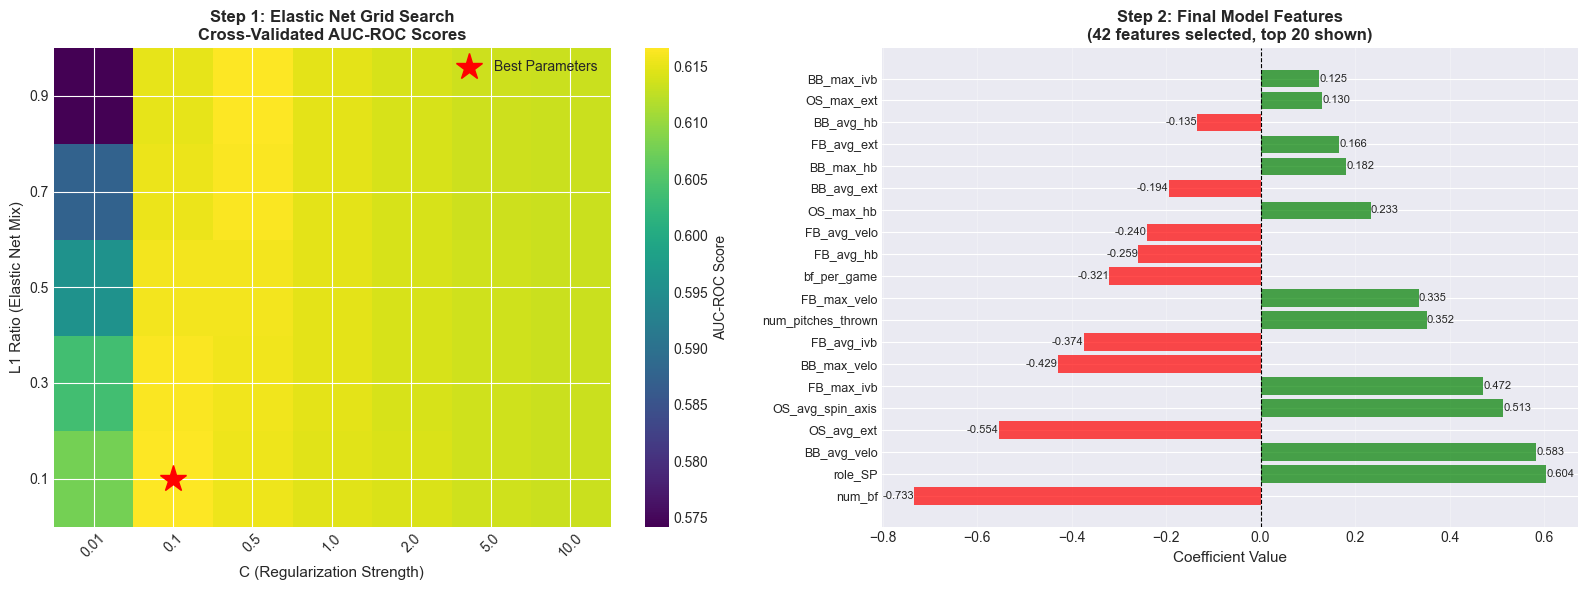

In [9]:
# Visualization: Elastic Net Grid Search Results and Feature Selection
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grid Search Results Heatmap
cv_results = grid_search.cv_results_
C_values = param_grid['C']
l1_ratios = param_grid['l1_ratio']
scores_matrix = np.zeros((len(l1_ratios), len(C_values)))

for i, l1_ratio in enumerate(l1_ratios):
    for j, C in enumerate(C_values):
        params = {'C': C, 'l1_ratio': l1_ratio}
        idx = [k for k, p in enumerate(cv_results['params']) if p == params][0]
        scores_matrix[i, j] = cv_results['mean_test_score'][idx]

im = axes[0].imshow(scores_matrix, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_xticks(range(len(C_values)))
axes[0].set_xticklabels(C_values, rotation=45)
axes[0].set_yticks(range(len(l1_ratios)))
axes[0].set_yticklabels(l1_ratios)
axes[0].set_xlabel('C (Regularization Strength)', fontsize=11)
axes[0].set_ylabel('L1 Ratio (Elastic Net Mix)', fontsize=11)
axes[0].set_title('Step 1: Elastic Net Grid Search\nCross-Validated AUC-ROC Scores', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[0], label='AUC-ROC Score')

# Mark best parameters
best_C_idx = C_values.index(grid_search.best_params_['C'])
best_l1_idx = l1_ratios.index(grid_search.best_params_['l1_ratio'])
axes[0].plot(best_C_idx, best_l1_idx, 'r*', markersize=20, label='Best Parameters')
axes[0].legend()

# Plot 2: Top Selected Features (Final Model Coefficients)
top_n = min(20, len(coef_df2))
top_features = coef_df2.head(top_n)

colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
bars = axes[1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'], fontsize=9)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title(f'Step 2: Final Model Features\n({n_selected} features selected, top {top_n} shown)', 
                 fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['Coefficient'])):
    width = bar.get_width()
    label_x = width if width >= 0 else width
    axes[1].text(label_x, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right',
                va='center', fontsize=8)

plt.tight_layout()
plt.show()


---

## Model 3: Full Model (Unmodifiable + Modifiable)


In [10]:
# Model 3: Full model (combine Model 1 and Model 2 features)
# Start with Model 1 features
X3 = df_model[model1_features].copy()
# Handle categorical variables
X3 = pd.get_dummies(X3, columns=['birth_country'], prefix='country', drop_first=True)

# Add Model 2 modifiable features (all of them, before encoding)
X3_modifiable = df_model[model2_features].copy()
# Handle categorical variable (pitcher_role)
X3_modifiable = pd.get_dummies(X3_modifiable, columns=['pitcher_role'], prefix='role', drop_first=True)

# Combine all features
X3 = pd.concat([X3, X3_modifiable], axis=1)

# Use the same train/test split for all models
X3_train = X3.loc[train_idx]
X3_test = X3.loc[test_idx]
# y_train and y_test already defined

# Standardize features
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_test_scaled = scaler3.transform(X3_test)

# Fit logistic regression
model3 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model3.fit(X3_train_scaled, y_train)

# Predictions
y3_pred = model3.predict(X3_test_scaled)
y3_pred_proba = model3.predict_proba(X3_test_scaled)[:, 1]

# Metrics
print(f"\nTotal features: {X3.shape[1]}")
print(f"\nAccuracy: {accuracy_score(y_test, y3_pred):.4f}")
print(f"Precision: {precision_score(y_test, y3_pred):.4f}")
print(f"Recall: {recall_score(y_test, y3_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y3_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y3_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y3_pred_proba):.4f}")

# Cross-validation
cv_scores = cross_val_score(model3, X3_train_scaled, y_train, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring='roc_auc')
print(f"\n5-Fold CV AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Total features: 82

Accuracy: 0.7373
Precision: 0.4049
Recall: 0.5709
F1-Score: 0.4738
AUC-ROC: 0.7238
Log Loss: 0.6128

5-Fold CV AUC-ROC: 0.7196 (+/- 0.0185)


In [11]:
# Store Model 3 results
model3_results = {
    'model': model3,
    'scaler': scaler3,
    'feature_names': X3.columns.tolist(),
    'y_test': y_test,
    'y_pred': y3_pred,
    'y_pred_proba': y3_pred_proba,
    'accuracy': accuracy_score(y_test, y3_pred),
    'precision': precision_score(y_test, y3_pred),
    'recall': recall_score(y_test, y3_pred),
    'f1': f1_score(y_test, y3_pred),
    'auc_roc': roc_auc_score(y_test, y3_pred_proba),
    'log_loss': log_loss(y_test, y3_pred_proba)
}

# Display coefficients
coef_df3 = pd.DataFrame({
    'Feature': X3.columns,
    'Coefficient': model3.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 20 Features by Absolute Coefficient:")
print(coef_df3.head(20).to_string(index=False))



Top 20 Features by Absolute Coefficient:
                   Feature  Coefficient
               age_squared    -1.028492
                       age     1.020034
                    num_bf    -0.953978
          OS_avg_spin_axis     0.758691
      prev_arm_inj_history     0.741545
                OS_avg_ext    -0.645232
        num_pitches_thrown     0.504571
country_Dominican Republic    -0.487618
               BB_avg_velo     0.466751
                   role_SP     0.465834
               country_USA    -0.455675
                FB_max_ivb     0.432558
         country_Nicaragua    -0.393203
                FB_avg_ivb    -0.366184
                BB_avg_ext    -0.285556
               FB_max_velo     0.278701
 country_Republic of Korea    -0.272193
         country_Venezuela    -0.269955
            country_Taiwan    -0.266578
               BB_max_velo    -0.256489


---

## Model Comparison and Visualizations


In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full'],
    'Accuracy': [model1_results['accuracy'], model2_results['accuracy'], model3_results['accuracy']],
    'Precision': [model1_results['precision'], model2_results['precision'], model3_results['precision']],
    'Recall': [model1_results['recall'], model2_results['recall'], model3_results['recall']],
    'F1-Score': [model1_results['f1'], model2_results['f1'], model3_results['f1']],
    'AUC-ROC': [model1_results['auc_roc'], model2_results['auc_roc'], model3_results['auc_roc']],
    'Log Loss': [model1_results['log_loss'], model2_results['log_loss'], model3_results['log_loss']]
})


print(comparison_df.to_string(index=False))



              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Log Loss
  Model 1: Baseline  0.815079   0.572917 0.421456  0.485651 0.679929  0.633364
Model 2: Modifiable  0.588095   0.256604 0.521073  0.343869 0.615182  0.666355
      Model 3: Full  0.737302   0.404891 0.570881  0.473768 0.723808  0.612819


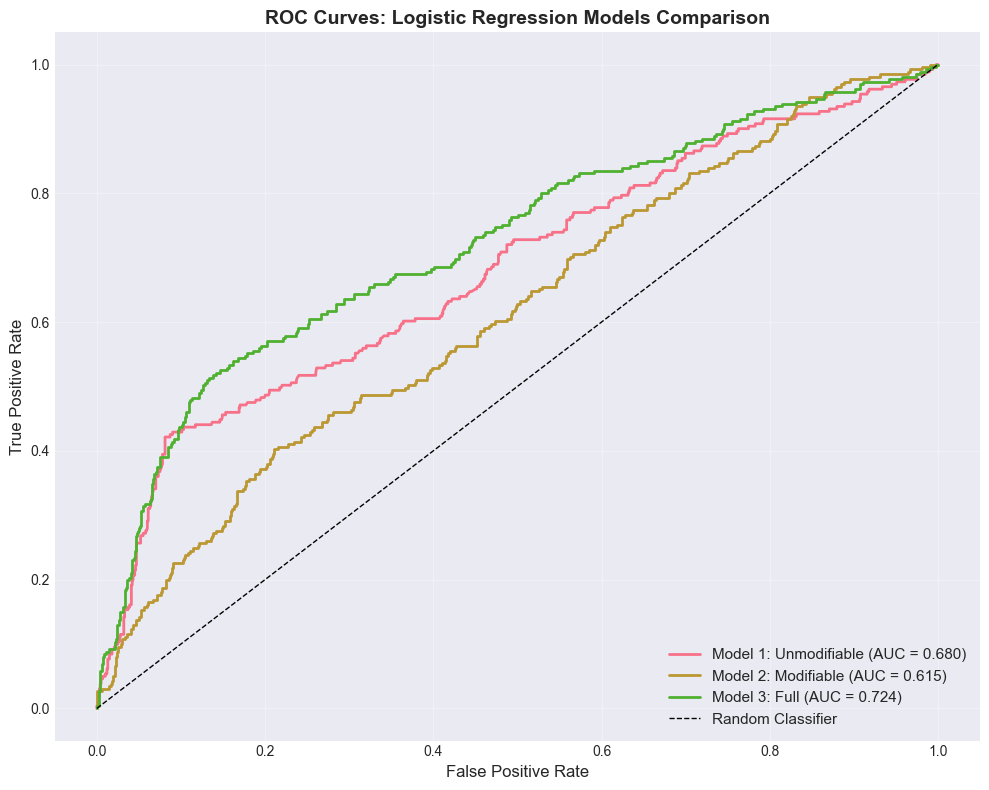

In [13]:
# Visualization 1: ROC Curves Comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC curves for all models
fpr1, tpr1, _ = roc_curve(model1_results['y_test'], model1_results['y_pred_proba'])
fpr2, tpr2, _ = roc_curve(model2_results['y_test'], model2_results['y_pred_proba'])
fpr3, tpr3, _ = roc_curve(model3_results['y_test'], model3_results['y_pred_proba'])

# Plot ROC curves
ax.plot(fpr1, tpr1, label=f"Model 1: Unmodifiable (AUC = {model1_results['auc_roc']:.3f})", linewidth=2)
ax.plot(fpr2, tpr2, label=f"Model 2: Modifiable (AUC = {model2_results['auc_roc']:.3f})", linewidth=2)
ax.plot(fpr3, tpr3, label=f"Model 3: Full (AUC = {model3_results['auc_roc']:.3f})", linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Logistic Regression Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


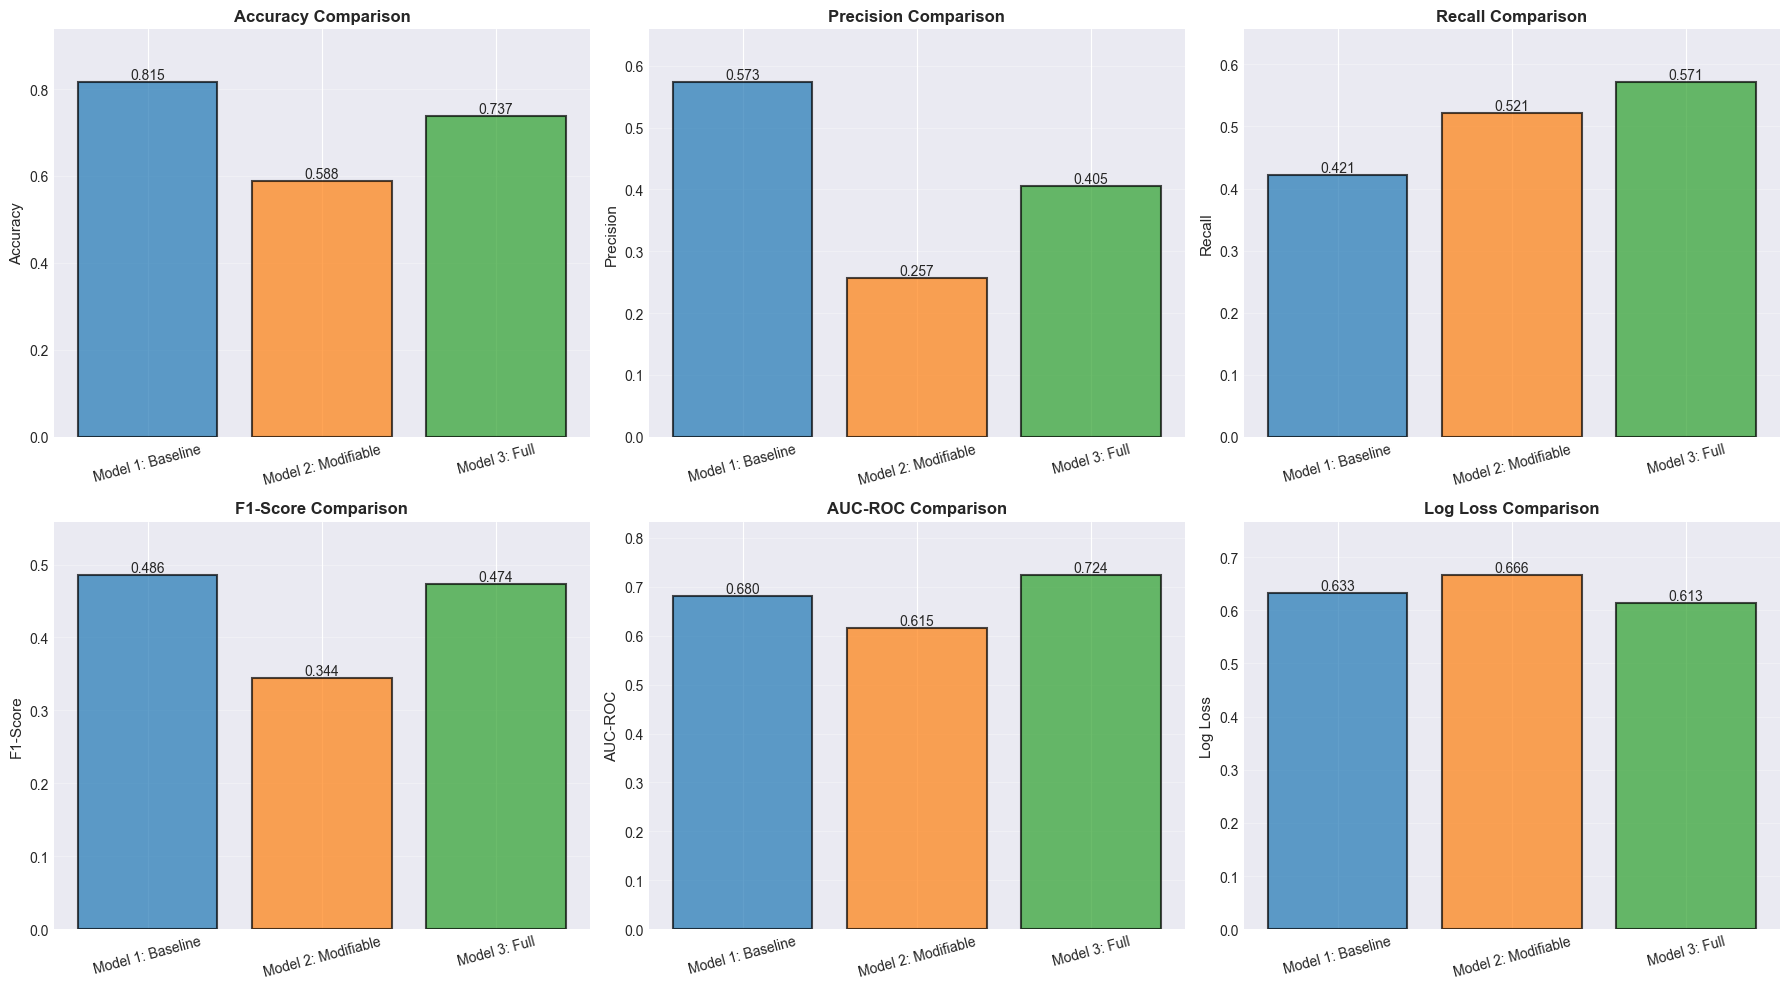

In [14]:
# Visualization 2: Performance Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, max(values) * 1.15])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


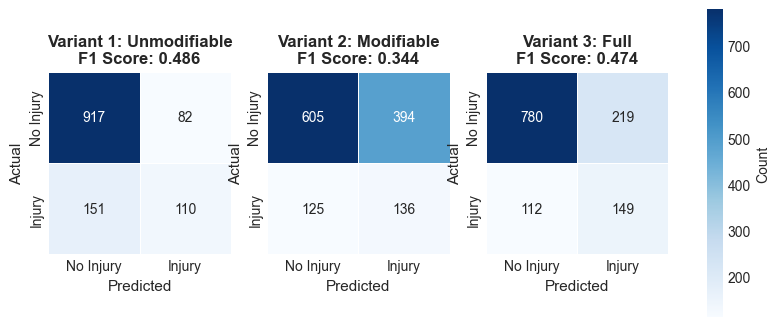

In [25]:
# Visualization 3: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Variant 1: Unmodifiable', 'Variant 2: Modifiable', 'Variant 3: Full']

heatmap_obj = None
for i, (results, name) in enumerate(zip(models_results, model_names)):
    cm = confusion_matrix(results['y_test'], results['y_pred'])
    heatmap_obj = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, square=True, linewidths=0.5)
    axes[i].set_title(f'{name}\nF1 Score: {results["f1"]:.3f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=11)
    axes[i].set_ylabel('Actual', fontsize=11)
    axes[i].set_xticklabels(['No Injury', 'Injury'])
    axes[i].set_yticklabels(['No Injury', 'Injury'])

cbar = fig.colorbar(heatmap_obj.collections[0], ax=axes, location='right', shrink=0.8)
cbar.set_label('Count')
plt.show()

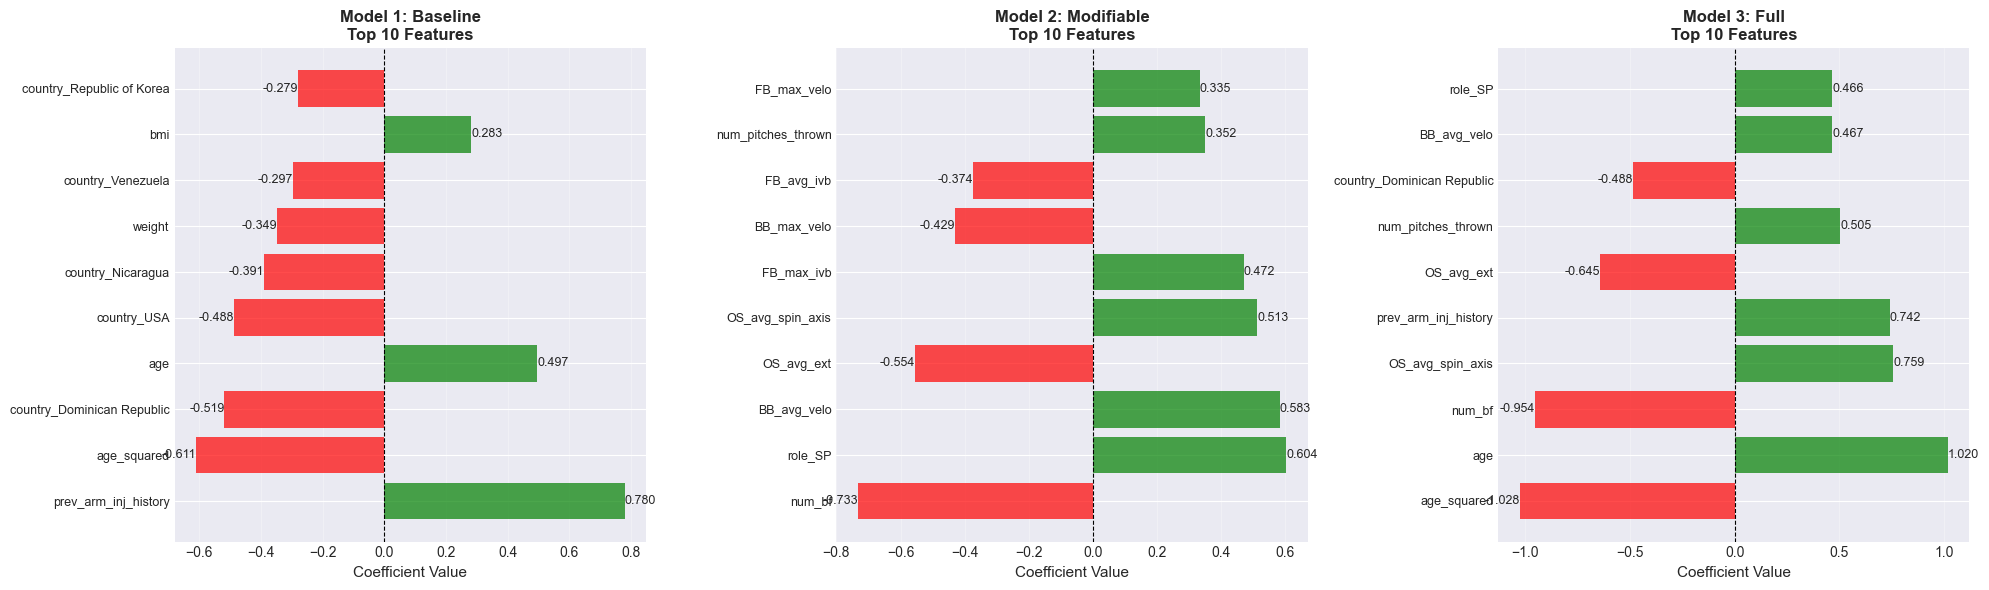

In [16]:
# Visualization 4: Top Feature Coefficients by Model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

coefficients = [coef_df1, coef_df2, coef_df3]
model_names = ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full']
n_top = 10

for i, (coef_df, name) in enumerate(zip(coefficients, model_names)):
    ax = axes[i]
    top_coef = coef_df.head(n_top)
    
    colors = ['red' if x < 0 else 'green' for x in top_coef['Coefficient']]
    bars = ax.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_coef)))
    ax.set_yticklabels(top_coef['Feature'], fontsize=9)
    ax.set_xlabel('Coefficient Value', fontsize=11)
    ax.set_title(f'{name}\nTop {n_top} Features', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for j, (bar, val) in enumerate(zip(bars, top_coef['Coefficient'])):
        width = bar.get_width()
        label_x = width if width >= 0 else width
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right',
                va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [18]:
# Visualization 5: Coefficient Comparison for Common Features
# Identify common features across models
common_features_model1 = set(X1.columns)
common_features_model2 = set(X2.columns)
common_features_model3 = set(X3.columns)

# Features that appear in Model 2 (modifiable) - most interesting for comparison
modifiable_features_in_model3 = common_features_model2.intersection(common_features_model3)

# Create comparison dataframe for modifiable features
coef_comparison = []
for feat in sorted(modifiable_features_in_model3):
    idx2 = list(X2.columns).index(feat)
    idx3 = list(X3.columns).index(feat)
    coef_comparison.append({
        'Feature': feat,
        'Model 2': model2.coef_[0][idx2],
        'Model 3': model3.coef_[0][idx3]
    })

coef_comp_df = pd.DataFrame(coef_comparison).head(15)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(coef_comp_df))
width = 0.35

bars1 = ax.barh(x - width/2, coef_comp_df['Model 2'], width, 
                label='Model 2: Modifiable Only', alpha=0.8, color='orange')
bars2 = ax.barh(x + width/2, coef_comp_df['Model 3'], width,
                label='Model 3: Full Model', alpha=0.8, color='green')

ax.set_yticks(x)
ax.set_yticklabels(coef_comp_df['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('Coefficient Comparison: Modifiable Features\n(Model 2 vs Model 3)', 
            fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


IndexError: index 42 is out of bounds for axis 0 with size 42

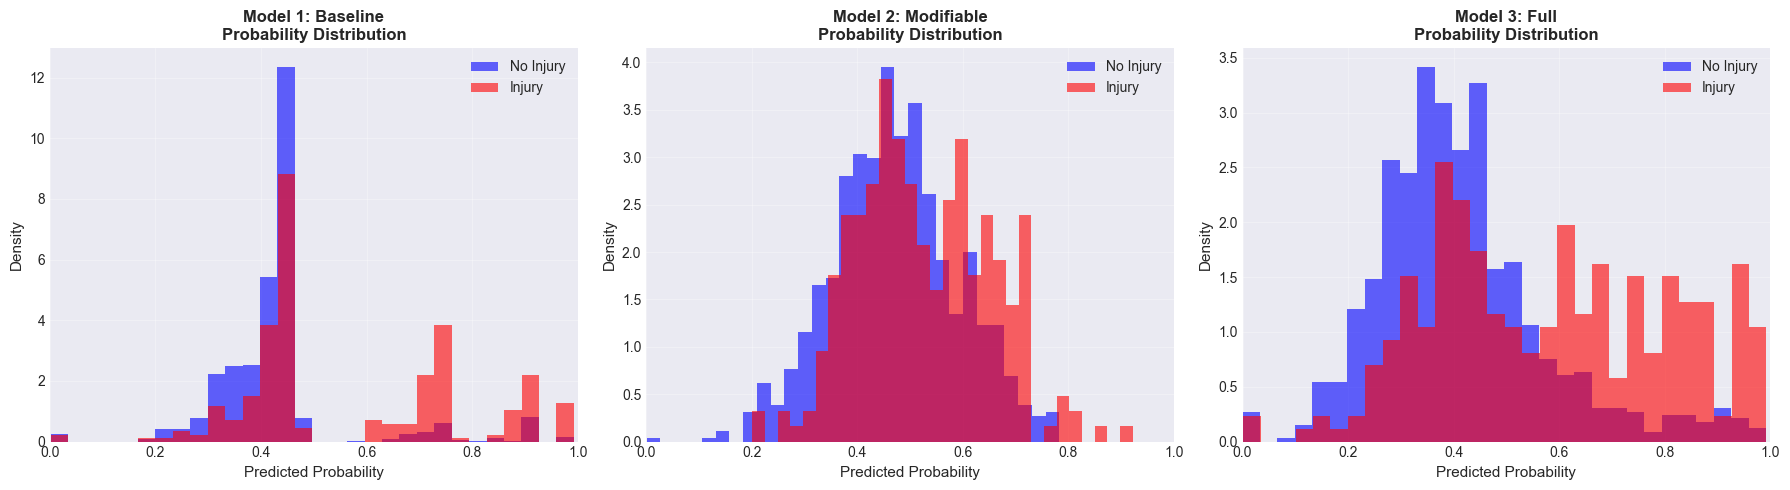

In [19]:
# Visualization 6: Prediction Probability Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pred_probas = [
    (model1_results['y_pred_proba'], model1_results['y_test'], 'Model 1: Baseline'),
    (model2_results['y_pred_proba'], model2_results['y_test'], 'Model 2: Modifiable'),
    (model3_results['y_pred_proba'], model3_results['y_test'], 'Model 3: Full')
]

for i, (proba, true_labels, name) in enumerate(pred_probas):
    ax = axes[i]
    
    # Separate predictions by actual class
    no_injury_proba = proba[true_labels == 0]
    injury_proba = proba[true_labels == 1]
    
    ax.hist(no_injury_proba, bins=30, alpha=0.6, label='No Injury', color='blue', density=True)
    ax.hist(injury_proba, bins=30, alpha=0.6, label='Injury', color='red', density=True)
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name}\nProbability Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


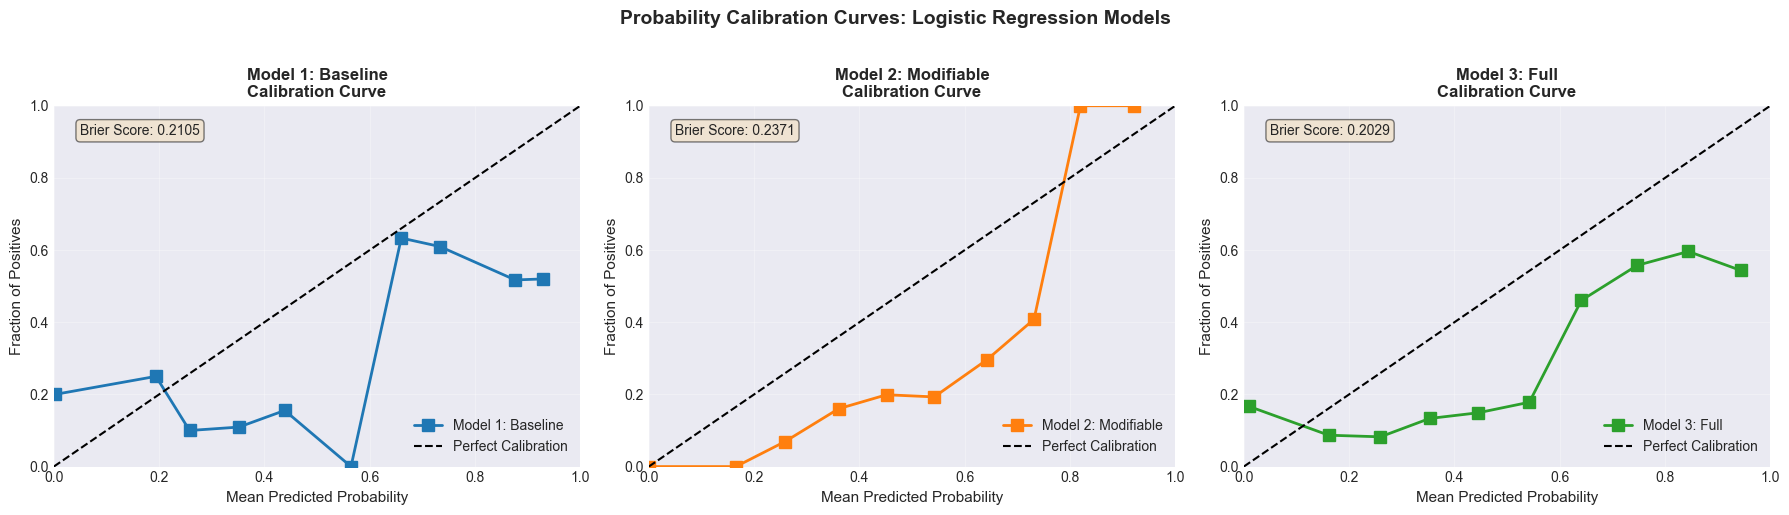

In [20]:
# Visualization 7: Probability Calibration Curves
# Calibration curves show how well the predicted probabilities match the actual probabilities
# A well-calibrated model should have predicted probabilities that match observed frequencies

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (results, name, color) in enumerate(zip(models_results, model_names, colors)):
    ax = axes[i]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        results['y_test'], 
        results['y_pred_proba'], 
        n_bins=10,
        strategy='uniform'
    )
    
    # Plot calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', 
           label=f'{name}', color=color, linewidth=2, markersize=8)
    
    # Plot perfect calibration line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1.5)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title(f'{name}\nCalibration Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Calculate Brier score (calibration metric)
    from sklearn.metrics import brier_score_loss
    brier_score = brier_score_loss(results['y_test'], results['y_pred_proba'])
    ax.text(0.05, 0.95, f'Brier Score: {brier_score:.4f}', 
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Probability Calibration Curves: Logistic Regression Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


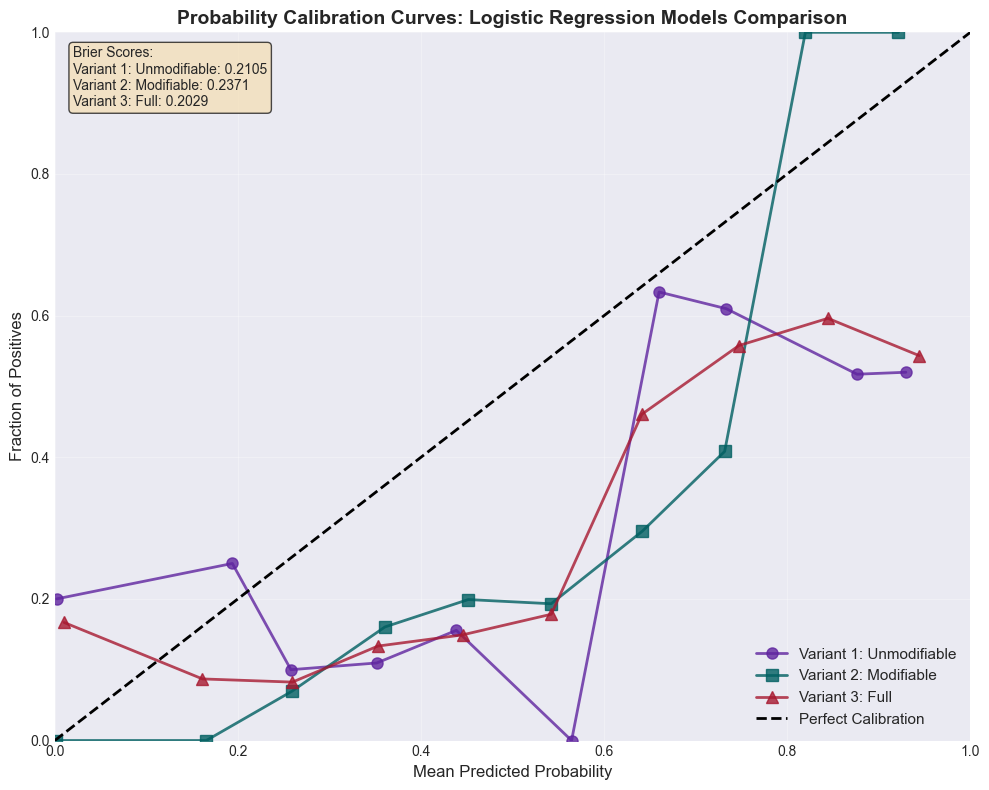

In [23]:
# Visualization 8: Combined Calibration Curve Comparison
# Show all three models on the same plot for easier comparison

fig, ax = plt.subplots(figsize=(10, 8))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Variant 1: Unmodifiable', 'Variant 2: Modifiable', 'Variant 3: Full']
colors = ['#5F249F', '#005F61', '#A71930']
markers = ['o', 's', '^']

for results, name, color, marker in zip(models_results, model_names, colors, markers):
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        results['y_test'], 
        results['y_pred_proba'], 
        n_bins=10,
        strategy='uniform'
    )
    
    # Plot calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, marker=marker, 
           label=f'{name}', color=color, linewidth=2, markersize=8, alpha=0.8)

# Plot perfect calibration line (diagonal)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Probability Calibration Curves: Logistic Regression Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Add Brier scores in legend or as text
from sklearn.metrics import brier_score_loss
brier_scores = [brier_score_loss(r['y_test'], r['y_pred_proba']) for r in models_results]
brier_text = '\n'.join([f'{name}: {score:.4f}' for name, score in zip(model_names, brier_scores)])
ax.text(
    0.02, 0.98, 
    f'Brier Scores:\n{brier_text}',
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
)

plt.tight_layout()
plt.show()
